In [1]:
import numpy as np
import torch
from torch import distributions as dist
import matplotlib.pyplot as plt
import argparse
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
mvn = dist.MultivariateNormal(torch.zeros(2), torch.eye(2))

x = torch.arange(-3, 3, 0.01)
y = torch.arange(-3, 3, 0.01)
X, Y = torch.meshgrid(x, y)
Z = torch.dstack((X, Y))

log_prob = mvn.log_prob(Z)

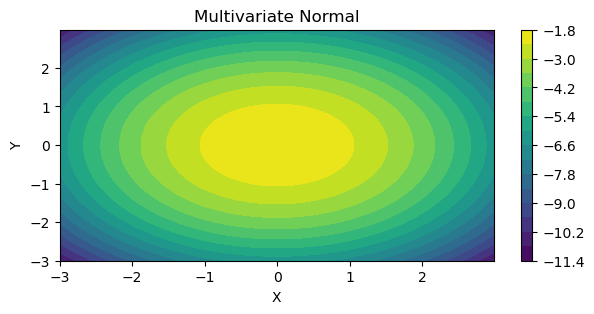

In [3]:
plt.figure(figsize=(7, 3))
plt.contourf(X, Y, log_prob, levels=15)
plt.colorbar()
plt.xlabel(xlabel='X')
plt.ylabel(ylabel='Y')
plt.title('Multivariate Normal')
plt.show()

In [4]:
from torch.autograd import Variable
import scipy.stats as st

In [5]:
position = torch.randn(2, requires_grad=True)
print(f'position = {position}')

mvn_output = mvn.log_prob(position)
print(f'log prob = {mvn_output}')
print(mvn_output.grad_fn)

mvn_output.backward()
print(f'gradient = {position.grad}') ## dVdq

# must zero out gradients
position.grad.zero_()
print(position.grad)

position = tensor([ 0.2678, -2.3851], requires_grad=True)
log prob = -4.718016147613525
gradient = tensor([-0.2678,  2.3851])
tensor([0., 0.])


In [6]:
def log_probs_to_img(dist, extent=None, num=100):

    if extent is None:
        extent = (-3, 3, -3, 3)

    X, Y = torch.meshgrid(torch.linspace(*extent[:2], num), torch.linspace(*extent[2:], num))
    #Z = np.array([np.exp(-neg_log_p(j)) for j in np.array((X.ravel(), Y.ravel())).T]).reshape(X.shape)
    Z = torch.dstack((X, Y))

    log_probs = dist.log_prob(Z)
    
    return log_probs, extent

In [7]:
def leapfrog(q, p, dist, path_len, step_size):
    
    #q, p = q.clone(), p.clone()
    output = -dist.log_prob(q)
    output.backward()
    p -= step_size * q.grad / 2
    q.grad.zero_()

    for _ in range(int(path_len / step_size) - 1):

        q.grad.zero_()
        with torch.no_grad():
            q += step_size * p
        output = -dist.log_prob(q)
        output.backward()
        p -= step_size * q.grad
        
    output = -dist.log_prob(q)
    output.backward()
    
    with torch.no_grad():
        q += step_size * p
    
    p -= step_size * q.grad / 2

    return q, -p 

In [13]:
def hamiltonian_monte_carlo(n_samples, dist, initial_position, path_len=1, step_size=0.5):
    """Run Hamiltonian Monte Carlo sampling.

    Parameters
    ----------
    n_samples : int
        Number of samples to return
    negative_log_prob : callable
        The negative log probability to sample from
    initial_position : np.array
        A place to start sampling from.
    path_len : float
        How long each integration path is. Smaller is faster and more correlated.
    step_size : float
        How long each integration step is. Smaller is slower and more accurate.

    Returns
    -------
    np.array
        Array of length `n_samples`.
    """    
    # autograd magic
    #dVdq = grad(negative_log_prob)

    # collect all our samples in a list
    samples = [initial_position]
    param_samples = []
    momentum_samples = []
    # Keep a single object for momentum resampling
    momentum = torch.distributions.Normal(0, 1)

    # If initial_position is a 10d vector and n_samples is 100, we want 100 x 10 momentum draws
    # we can do this in one call to np.random.normal, and iterate over rows
    size = (n_samples,) + initial_position.shape[:1]
    for idx, p0 in tqdm(enumerate(momentum.sample(size)), total=size[0]):

        q0 = samples[-1]
        #print(f'starting q0 = {q0}, p0 = {p0}')

        # Check Metropolis acceptance criterion
        start_log_p = -dist.log_prob(q0) - torch.sum(momentum.log_prob(p0))
        #print(f'start_log_p: {start_log_p} = dist.log_prob({q0}) - torch.sum({p0})')

        # Integrate over our path to get a new position (q_new) and momentum (p_new)
        q_new, p_new = leapfrog(
            q=q0,
            p=p0,
            dist=dist,
            path_len=path_len,
            step_size=step_size
            )

        #print(f'q_new = {q_new}, p_new = {p_new}')

        new_log_p = -dist.log_prob(q_new) - torch.sum(momentum.log_prob(p_new))
        #print(f'new_log_p: {new_log_p} = dist.log_prob({q_new}) - torch.sum({p_new})')
        
        if torch.log(torch.rand(1)) < start_log_p - new_log_p:
            #print(f'accept q_new = {q_new}')
            param_samples.append(q_new.clone())
            momentum_samples.append(p_new.clone())
        else:
            #samples.append(np.copy(samples[-1]))
            #print(f'reject and accept q0 = {q0}')
            param_samples.append(q0.clone())
            momentum_samples.append(p0.clone())
        
    param_samples = np.vstack([tens.detach().numpy() for tens in param_samples])
    momentum_samples = np.vstack([tens.detach().numpy() for tens in momentum_samples])   
        
    return param_samples, momentum_samples

100%|██████████| 10/10 [00:00<00:00, 88.77it/s]


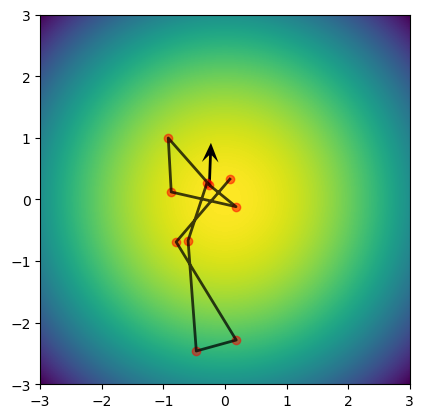

In [33]:
mvn = dist.MultivariateNormal(torch.zeros(2), torch.eye(2))
init_pos = torch.randn(2, requires_grad=True)

Z, extent = log_probs_to_img(mvn, (-3, 3, -3, 3), num=200)

## positions != samples (TO DO!!!)
samples, momentums = hamiltonian_monte_carlo(
    n_samples=10,
    dist=mvn,
    initial_position=init_pos,
    path_len=1,
    step_size=0.01
    )

steps = slice(None, None, 15)

plt.quiver(
    samples[steps, 0], samples[steps, 1], momentums[steps, 0], momentums[steps, 1], 
    headwidth=6, scale=10, headlength=7
    )
# #plt.quiver(positions[0], positions[1], momentums[0], momentums[1], headwidth=6, headlength=7, scale=10, alpha=0.8)
plt.plot(samples[:, 0], samples[:, 1], 'k-', lw=2, alpha=0.75)

plt.imshow(Z, extent=extent);
plt.scatter(
    samples[:, 0], samples[:, 1],
    color='red', alpha=0.5
    );